In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import math
import cv2
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.models import Model

In [14]:
DATASET_NAME = 'CIFAR10'

TRAIN_PATH = './dataset/CIFAR10/train/'

In [15]:
MODEL_DIR = 'model/' + DATASET_NAME
 
MODEL_SAVE_PATH = MODEL_DIR + '/ResNet_model.h5'

img_width, img_height = 224, 224
batch_size = 16
epochs = 1000
learning_rate = 2e-5
momentum = 0.9
early_stop_count = 10

In [16]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [17]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
    )

In [18]:
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

num_train_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)
print('訓練資料的數量 => ', num_train_samples)
print('類別數量 => ', num_classes)
print('類別名稱、index => ', train_generator.class_indices)

Found 40000 images belonging to 10 classes.
訓練資料的數量 =>  40000
類別數量 =>  10
類別名稱、index =>  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [19]:
validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

num_validation_samples = len(validation_generator.filenames)
print('驗證資料的數量 => ', num_validation_samples)

Found 10000 images belonging to 10 classes.
驗證資料的數量 =>  10000


In [8]:
model_ResNet = applications.ResNet50(include_top= None,input_shape=(224,224,3),weights= 'imagenet')

C:\Users\mb207\Anaconda3\envs\opencv\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
model_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
x=model_ResNet.output
x=Flatten()(x)
x=Dense(4096, activation='relu')(x)
x=Dense(2048, activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(1024, activation='relu')(x)
preds=Dense(10, activation='softmax')(x)

In [12]:
model=Model(inputs=model_ResNet.input,outputs=preds)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
early_stopping = EarlyStopping(patience=early_stop_count)
checkpointer = ModelCheckpoint(MODEL_SAVE_PATH, verbose=1, save_best_only=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10000000
2500/2500 [==============================] - 1452s 581ms/step - loss: 0.4590 - acc: 0.8472 - val_loss: 0.3408 - val_acc: 0.8878

Epoch 00001: val_loss improved from inf to 0.34085, saving model to model/CIFAR10/ResNet_model.h5
Epoch 2/10000000
2500/2500 [==============================] - 1414s 566ms/step - loss: 0.1452 - acc: 0.9512 - val_loss: 0.3724 - val_acc: 0.8922

Epoch 00002: val_loss did not improve from 0.34085
Epoch 3/10000000
2500/2500 [==============================] - 1414s 565ms/step - loss: 0.0753 - acc: 0.9754 - val_loss: 0.3253 - val_acc: 0.9141

Epoch 00003: val_loss improved from 0.34085 to 0.32533, saving model to model/CIFAR10/ResNet_model.h5
Epoch 4/10000000
2500/2500 [==============================] - 1426s 570ms/step - loss: 0.0525 - acc: 0.9817 - val_loss: 0.3456 - val_acc: 0.9144

Epoch 00004: val_loss did not improve from 0.32533
Epoch 5/10000000
25

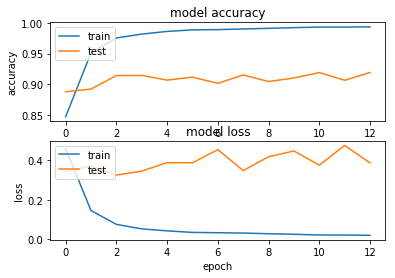

In [13]:
model.compile(optimizer=optimizers.Adam(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit_generator(generator=train_generator,
                    epochs=epochs,
                    callbacks=[early_stopping,checkpointer], 
                    validation_data=validation_generator)


model.save_weights(MODEL_SAVE_PATH)

print("[INFO] Best loss: {}".format(np.min(history.history['loss'])))
print("[INFO] Best acc: {}".format(np.max(history.history['acc'])))
print("[INFO] Best val_loss: {}".format(np.min(history.history['val_loss'])))
print("[INFO] Best val_acc: {}".format(np.max(history.history['val_acc'])))

plt.figure(1)

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict Data

In [21]:
import os
import pandas as pd
from keras.models import load_model 

In [15]:
TESTDIR = './dataset/CIFAR10/test/'

In [16]:
label = []
for v in train_generator.class_indices:label.append(v)

In [26]:
true_label = []
predict_label = []
predict_result = []

In [27]:
for i in os.listdir(TESTDIR):
    for k in os.listdir(TESTDIR + i):
        print(i)
        image = load_img(TESTDIR + str(i) + '/' + str(k), target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255
        image = np.expand_dims(image, axis=0)
        predict = model.predict(image)
        predict = np.argmax(predict,axis=1)
        pl = label[int(predict)]
        true_label.append(i)
        predict_label.append(pl)
        if i == pl:
            predict_result.append(1)
            print('True')
        else:
            predict_result.append(0)
            print('False')

airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
True
airplane
True
airpl

True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
True
airplane
False
airplane
False
airplane
True
airplane


True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
False
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
False
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
False
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True


True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
False
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
automobile
True
au

True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
False
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
False
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
False
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
False
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
False
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True
bird
True


True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
False
cat
False
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
False
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
True
cat
True
cat
True
cat
False
cat
True
cat
False
cat
True
cat
True
cat
True
ca

True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
False
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
False
deer
True
deer
False
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer


True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
True
deer
False
deer
True
deer
True
deer
True

True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
False
dog
True
dog
False
dog
False
dog
True
dog
True
dog
True
dog
False
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
True
dog
T

True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog
True
frog


True
horse
True
horse
True
horse
True
horse
False
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
horse
True
hors

True
ship
True
ship
True
ship
False
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship

True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
False
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
ship
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
False
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
False
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truc

True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
False
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
False
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
False
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
truck
True
tr

In [29]:
len(true_label)

10000

In [30]:
df = pd.DataFrame(columns=['TrueLabel', 'PredictLabel', 'PredictResult'])
df['TrueLabel'] = true_label
df['PredictLabel'] = predict_label
df['PredictResult'] = predict_result

In [31]:
testAcc = len(df.loc[df['PredictResult']==1])/len(predict_result)

In [32]:
print('Test accuracy ： ' + str(testAcc))

Test accuracy ： 0.9386


In [33]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_mtx = confusion_matrix(true_label, predict_label) 
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(classification_report(true_label, predict_label, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.94      0.92      0.93      1000
         cat       0.89      0.85      0.87      1000
        deer       0.92      0.95      0.94      1000
         dog       0.91      0.86      0.88      1000
        frog       0.95      0.97      0.96      1000
       horse       0.95      0.97      0.96      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

